In [9]:
import sys
import numpy as np
from numpy import pi
from scipy.special import jv, hankel2
from scipy.sparse import dia_matrix
from matplotlib import pyplot as plt
sys.path.insert(1, '../../../eispy2d/library/')

# Import module
import configuration as cfg
import experiment as exp
import inputdata as ipt
import analytical as ana
import mom_cg_fft as mom
import imsa_pso

In [2]:
# Transform cartesian coordinates into polar ones
def cart2polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    phi[phi<0] = 2*pi + phi[phi<0]
    return rho, phi

In [3]:
# General parameters
lambdab = 1.
saved_files_path = './data/'

# Set up configurations
config = cfg.Configuration(name='2x2',
                           wavelength=lambdab,
                           background_permittivity=1.0,
                           image_size=[2., 2.],
                           perfect_dielectric=True,
                           number_sources=10,
                           number_measurements=10)
config.save(file_path=saved_files_path)

In [4]:
# Configuration of resolution reconstruction process
resolution = (7, 7)
number_iterations = 20000
number_particles = 250
MIWI = 20000  # Maximum number of iterations without improvement

# Set up methods
methods = imsa_pso.IMSA_PSO(config,
                            resolution,
                            alias='pso',
                            number_particles=250,
                            number_iterations=number_iterations,
                            max_iterations_without_improvement=MIWI)

# Build input object
scenario = ipt.InputData(name='dielectric_cylinder',
                         configuration_filename=config.name,
                         resolution=resolution,
                         noise=0.,
                         compute_map_error=True,
                         compute_residual_error=True,
                         compute_totalfield_error=True)

# Solve forward problem analytically
analytical_solution = ana.Analytical(config, number_terms=100)
analytical_solution.solve(scenario, contrast=1.,
                          SAVE_MAP=True,
                          radius_proportion=0.4)

# Se o algoritmo começar pela solução analítica, ele vai achar outra melhor?

Seja a função objetivo dada por:

$$ min f_0(\chi, E_{z}) = \frac{\sum_{m=1}^M |E_{z,m}^s + \sum_{n=1}^N h_{mn}\chi_nE_{z,n}|^2}{\sum_{m=1}^M |E_{z,m}^s|^2} + \frac{\sum_{n=1}^N |E_{z,n}^i - E_{z,n} - \sum_{m=1}^M h_{nm}\chi_mE_{z,m}|^2}{\sum_{n=1}^N |E_{z,n}^i|^2} $$

Essa é a soma ponderada dos resíduos das equações de dados e estados. A solução analítica para $\chi$ e $E_z$ pode ser calculada considerando o problema do espalhamento sobre um cilindro circular. Nesse caso o valor da função-objetivo é calculado por:

Exact solution evaluation: 4.214e-01


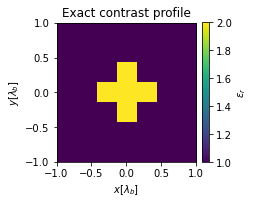

In [10]:
# Computing the incident field
M = config.NM
N = resolution[0]*resolution[1]
x, y = cfg.get_coordinates_ddomain(configuration=config, resolution=resolution)
rho, phi = cart2polar(x, y)
Eiz = analytical_solution.incident_field(resolution)
cell_area = np.sqrt((x[0, 1]-x[0, 0])*(y[1, 0]-y[0, 0])/pi)
xm, ym = cfg.get_coordinates_sdomain(config.Ro, config.NM)
kb = config.kb

# Data equation
HD = np.zeros((M, N), dtype=complex)
for m in range(M):
    R = np.sqrt((x-xm[m])**2 + (y-ym[m])**2).flatten()
    HD[m, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)

# State Equation
HS = np.zeros((N, N), dtype=complex)
for k in range(N):
    i, j = np.unravel_index(k, resolution)
    R = np.sqrt((x-x[i, j])**2 + (y-y[i, j])**2).flatten()
    HS[k, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)
    HS[k, R==0] = 1j/2*(pi*kb*cell_area*hankel2(1, kb*cell_area)-2j)

# Exact contrast
chi = scenario.epsilon_r/config.epsilon_rb - 1

# Evaluation of the exact solution
fxexct = imsa_pso.Phi_eval([dia_matrix((chi.flatten(), 0), shape=(N, N))],
                           [scenario.et],
                           [HD],
                           [HS],
                           scenario.es,
                           [Eiz])

# Plot the exact constrast profile
fig, axis = plt.subplots(ncols=2, sharey=True)
img = axis[0].imshow(scenario.epsilon_r, extent=[-config.Lx/2/config.lambda_b, config.Lx/2/config.lambda_b, -config.Ly/2/config.lambda_b, config.Ly/2/config.lambda_b])
clb = fig.colorbar(img, ax=axis[0], fraction=0.046, pad=0.04)
clb.set_label(r'$\epsilon_r$')
axis[0].set_xlabel(r'$x [\lambda_b]$')
axis[0].set_ylabel(r'$y [\lambda_b]$')
axis[0].set_title('Exact contrast profile')
axis[1].set_visible(False)

# Print fitness evaluation
print('Exact solution evaluation: %.3e' % fxexct)

A inicialização do algoritmo do PSO é feita através de uma randomização dos valores dos valores de contraste em cada píxel e o campo é calculado a partir da equação de estados com a Aproximação de Born de Primeira Ordem. Em um teste realizado desta forma, a solução final após 20000 iterações ainda ficou um pouco longe em termos da avaliação da função objetivo (cerca de 10 vezes maior).

Como o objetivo é verificar se o algoritmo vai encontrar alguma solução com uma avaliação mais baixa que a analítica, foi experimentado alterar código da seguinte forma: após a inicialização das soluções conforme descrito no parágrafo anterior, a primeira solução é substituída pela solução analítica. É de se esperar que a melhor solução da primeira iteração seja essa. E será observado se vai ser encontrada outra solução com uma avaliação menor ao longo da convergência:

In [6]:
result = methods.solve(scenario, max_contrast=1.0, print_info=True, number_executions=1, run_parallelly=False)

Method: IMSA-PSO
Alias: pso
Problem configuration: 2x2
Instance: dielectric_cylinder
Number of particles (P): 250
c1 = 2.0, c2 = 2.0, w = 0.4
Scaling steps (S): 1
Resolution steps: (7, 7)
Number of iterations: 20000
Number of executions: 1
Minimum contrast allowed: 0.000e+00
Maximum contrast allowed: 1.000e+00
Storing the best recovered image
Percent step for convergence sampling: 10.0
----------------------------------------
Scaling iteration 0 - Resolution:  (7, 7) , Area 4.000000
  PSO Iteration 0 - Best Phi(x): 4.214e-01
  PSO Iteration 2000 - Best Phi(x): 1.312e-01
  PSO Iteration 4000 - Best Phi(x): 1.207e-01
  PSO Iteration 6000 - Best Phi(x): 1.200e-01
  PSO Iteration 8000 - Best Phi(x): 1.196e-01
  PSO Iteration 10000 - Best Phi(x): 1.196e-01
  PSO Iteration 12000 - Best Phi(x): 1.196e-01
  PSO Iteration 14000 - Best Phi(x): 1.196e-01
  PSO Iteration 16000 - Best Phi(x): 1.196e-01
  PSO Iteration 18000 - Best Phi(x): 1.196e-01
  PSO Iteration 19999 - Best Phi(x): 1.196e-01


Como se pode observar, após 10% das iterações, foi encontrada uma solução com uma avaliação aproximadamente 4 vezes menor. Após 40% das iterações, não foi encontrada alguma solução com um valor de avaliação significantemente menor. Vejamos a imagem recuperada no final:

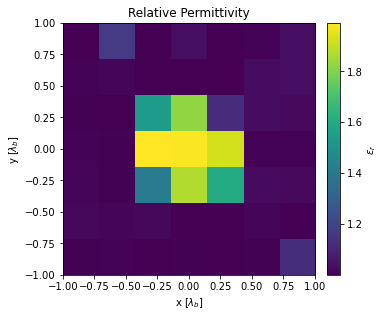

In [7]:
result.plot_map(show=True)

A solução final é parecida com a solução analítica. As diferenças são alguns pixels na borda com um valor pouco acima do *background* e os valores nas diagonais do desenho da solução analítica (que pode ser interpretado como uma espécie de suavização da função talvez).

O fato dessa solução não ter mudado a partir de 40% das iterações pode talvez ser interpretado como: a solução analítica é um ponto dentro da bacia de atração da função objetivo e o mínimo seria essa solução final obtida. Isso não responde se existem outras bacias de atração dentro da função que tenham um valor de função objetivo ainda menor. Essas outras bacias poderiam talvez serem encontradas no procedimento de inicialização totalmente aleatório. Mas é possível que demorem muitas iterações para serem encontradas pelo algoritmo. Talvez um outro algoritmo como o L-SHADE poderia encontrar essas outras bacias com menos iterações.

Mas, de fato, considerando essa formulação de função objetivo, tem outras soluções com avaliação menor que a exata. Poderíamos perguntar se essas soluções sempre estão na bacia da solução exata ou as soluções que estão dentro da bacia da solução exata sempre estão pouco distantes da exata. Além disso, é necessário recordar que essa instância foi gerada a partir de um problema analítico, ou seja, os erros nos dados de entrada são bem pequenos. Por causa disso, poderíamos nos perguntar se, com dados menos precisos, a posição da solução exata dentro da bacia e a existências de outras bacias com mínimos menores iriam ser semelhantes aos observados nessa instância.

Por fim, uma outra pergunta que poderia ser levantada a partir desse estudo é se uma malha com mais nós mudaria o que foi observado. Pelo fato disso significar um problema com mais variáveis ainda, isso com certeza dificultaria o processo de algoritmo normal chegar a bacia da solução analítica. No entanto, esse tipo de caso poderia trazer mais respostas à questão de ter ou não outras bacias com mínimos locais mais baixos que da bacia da analítica.